In [519]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn

In [520]:
apple = yf.Ticker("AAPL")
stock_df = apple.history(start="2024-01-01", end="2025-12-31")
stock_df.reset_index(inplace=True)
stock_df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
stock_df


,Date,Open,High,Low,Close,Volume
0,2024-01-02 00:00:00-05:00,186.033057,187.315366,182.792518,184.532074,82488700
1,2024-01-03 00:00:00-05:00,183.120556,184.770652,182.335262,183.150375,58414500
2,2024-01-04 00:00:00-05:00,181.062929,181.997322,179.800520,180.824371,71983600
3,2024-01-05 00:00:00-05:00,180.903872,181.669266,179.094727,180.098694,62303300
4,2024-01-08 00:00:00-05:00,181.003268,184.492330,180.416793,184.452560,59144500
...,...,...,...,...,...,...
277,2025-02-10 00:00:00-05:00,229.570007,230.589996,227.199997,227.649994,33115600
278,2025-02-11 00:00:00-05:00,228.199997,235.229996,228.130005,232.619995,53718400
279,2025-02-12 00:00:00-05:00,231.199997,236.960007,230.679993,236.869995,45243300
280,2025-02-13 00:00:00-05:00,236.910004,242.339996,235.570007,241.529999,53614100


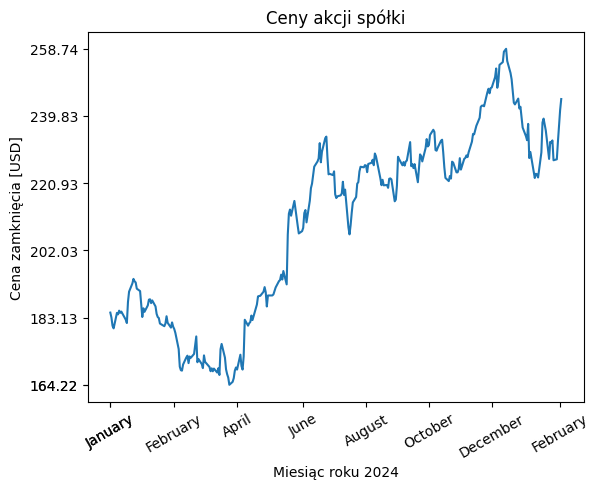

In [521]:
axes = sns.lineplot(data=stock_df, x='Date', y='Close')

x_ticks = [stock_df['Date'].iloc[0]]
x_ticks += list(stock_df['Date'].iloc[::len(stock_df)//7])

x_ticks_labels = [stock_df['Date'].dt.month_name().iloc[0]]
x_ticks_labels += list(stock_df['Date'].dt.month_name().iloc[::len(stock_df)//7])

y_min = stock_df['Close'].min()
y_max = stock_df['Close'].max()
# Minimalny punkt
y_ticks = [y_min]
# Kilka punktów pomiędzy wartością minimalną, a maksymalną
y_ticks += list([y_min + i * (y_max-y_min)/5 for i in range(5)])  
# Maksymalny punkt
y_ticks.append(y_max) 

# Ustawienie rozdziałki opisów osi X i Y
axes.set_xticks(ticks=x_ticks)
axes.set_xticklabels(labels=x_ticks_labels, rotation=30)
axes.set_yticks(y_ticks)
# Opis wykresu
plt.xlabel('Miesiąc roku 2024')
plt.ylabel('Cena zamknięcia [USD]')
plt.title('Ceny akcji spółki')
plt.show()

c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


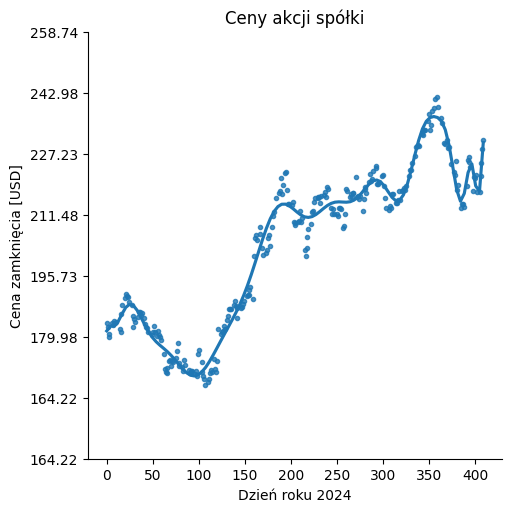

In [522]:
stock_df['DateNumeric'] = (stock_df['Date'] - stock_df['Date'].min()).dt.days
axes = sns.lmplot(data=stock_df, x='DateNumeric', y='Close', order=40, ci=None, markers=".")

y_min = stock_df['Close'].min()
y_max = stock_df['Close'].max()
y_ticks = [round(y_min,2)]  # Minimalny punkt
y_ticks += list([round(y_min + i * (y_max-y_min)/6,2) for i in range(6)])  # Kilka punktów pomiędzy
y_ticks.append(round(y_max,2))  # Maksymalny punkt

axes.set_yticklabels(labels=y_ticks)
# Opis wykresu
plt.xlabel('Dzień roku 2024')
plt.ylabel('Cena zamknięcia [USD]')
plt.title('Ceny akcji spółki')
plt.show()

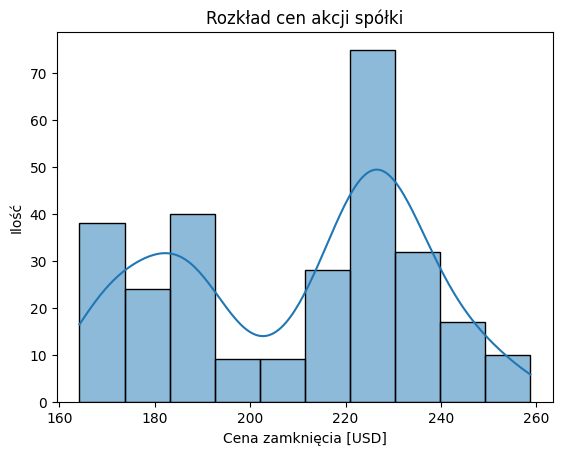

In [523]:
sns.histplot(data=stock_df['Close'],  kde=True).set_xlabel(xlabel='Cena zamkniecia [USD]')

# Opis wykresu
plt.xlabel('Cena zamknięcia [USD]')
plt.ylabel('Ilość')
plt.title('Rozkład cen akcji spółki')
plt.show()

In [524]:
n_past = 30
n_out = 1

close_prices = stock_df['Close'].values
X = []
y = []

for i in range(n_past, len(close_prices) - n_out + 1):
    X.append(close_prices[i - n_past:i])  # Sekwencja z n_past dni
    y.append(close_prices[i:i + n_out])   # Cena akcji z dnia następnego dla danej sekwencji
    
X = np.array(X)
y = np.array(y)

In [525]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [526]:
# Skalowanie danych
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_past)).reshape(-1, n_past, 1)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_past)).reshape(-1, n_past, 1)

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

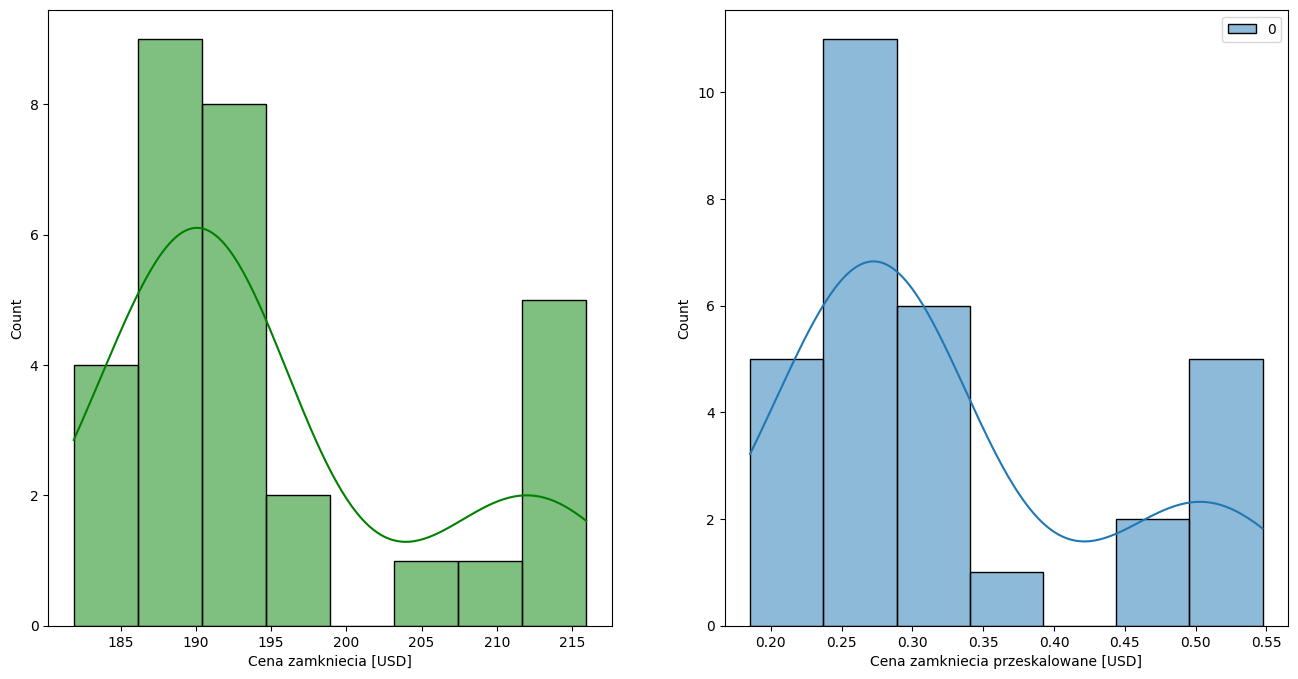

In [527]:
first_training_row = X_train[0]
first_training_row_scaled = X_train_scaled[0]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
sns.histplot(data=first_training_row, color='green', kde=True, ax=ax1).set_xlabel(xlabel='Cena zamkniecia [USD]')
sns.histplot(data=first_training_row_scaled, kde=True, ax=ax2).set_xlabel(xlabel='Cena zamkniecia przeskalowane [USD]')
plt.show()

In [ ]:
X_train_scaled = torch.tensor(np.array(X_train_scaled), dtype=torch.float32)
X_test_scaled = torch.tensor(np.array(X_test_scaled), dtype=torch.float32)
y_train_scaled = torch.tensor(np.array(y_train_scaled), dtype=torch.float32)
y_test_scaled = torch.tensor(np.array(y_test_scaled), dtype=torch.float32)

In [529]:
class StockPriceRNN(nn.Module):
    def __init__(self, input_data_features, hidden_size, num_layers, output_data_features):
       super().__init__()
       self.hidden_size = hidden_size
       self.num_layers = num_layers
       self.lstm = nn.LSTM(input_size=input_data_features, hidden_size=hidden_size, num_layers=num_layers,batch_first=True)
       self.fc = nn.Linear(in_features=hidden_size, out_features=output_data_features)
    
    def forward(self, x: torch.Tensor):
        # Format danych: [ilosc_wartw, ilosc_sekwencji, rozmiar_warstwy_ukrytej]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Pobieramy dane z sieci LSTM
        lstm_output, _ = self.lstm(x, (h0.detach(), c0.detach()))
        # Pobieramy ostatni stan ukryty
        last_lstm_hidden_state = lstm_output[:, -1, :]
        # Podajemy ostatni ukryty stan jako wyjście warstwy LSTM do warstwy liniowej
        output = self.fc(last_lstm_hidden_state)
        return output

In [530]:
# Hiperparametry modelu
input_data_features = 1
hidden_size = 32
num_layers = 2
output_data_features = 1
learning_rate = 0.002

# Inicjalizacja modelu
model = StockPriceRNN(input_data_features=input_data_features, hidden_size=hidden_size, num_layers=num_layers, output_data_features=output_data_features)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# funkcja błędu oraz optymalizator
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 1000
epochs = []
training_errors = []

batch_size = 64
train_dataset = TensorDataset(X_train_scaled, y_train_scaled)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    # Przełączamy model w tryb treningowy
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # Pobieramy predykcję dokonaną przez model
        outputs = model(batch_X)
        # Zerujemy gradient optymalizatora
        optimizer.zero_grad()
        # Obliczanie błędu modelu
        loss = criterion(outputs, batch_y)
        # Liczymy gradient dla obecnego błędu dla optymalizatora
        loss.backward()
        # Aktualizacja wag
        optimizer.step()
        

    # Zapisujemy numer iteracji (epokę) oraz błąd
    epochs.append(epoch + 1)
    training_errors.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Iteracja: {epoch+1}/{num_epochs}, błąd średnio-kwadratowy MSE: {loss:.5f}')



Iteracja: 10/1000, błąd średnio-kwadratowy MSE: 0.00045
Iteracja: 20/1000, błąd średnio-kwadratowy MSE: 0.00050
Iteracja: 30/1000, błąd średnio-kwadratowy MSE: 0.00026
Iteracja: 40/1000, błąd średnio-kwadratowy MSE: 0.00024
Iteracja: 50/1000, błąd średnio-kwadratowy MSE: 0.00033
Iteracja: 60/1000, błąd średnio-kwadratowy MSE: 0.00023
Iteracja: 70/1000, błąd średnio-kwadratowy MSE: 0.00045
Iteracja: 80/1000, błąd średnio-kwadratowy MSE: 0.00069
Iteracja: 90/1000, błąd średnio-kwadratowy MSE: 0.00027
Iteracja: 100/1000, błąd średnio-kwadratowy MSE: 0.00030
Iteracja: 110/1000, błąd średnio-kwadratowy MSE: 0.00033
Iteracja: 120/1000, błąd średnio-kwadratowy MSE: 0.00018
Iteracja: 130/1000, błąd średnio-kwadratowy MSE: 0.00034
Iteracja: 140/1000, błąd średnio-kwadratowy MSE: 0.00034
Iteracja: 150/1000, błąd średnio-kwadratowy MSE: 0.00034
Iteracja: 160/1000, błąd średnio-kwadratowy MSE: 0.00020
Iteracja: 170/1000, błąd średnio-kwadratowy MSE: 0.00060
Iteracja: 180/1000, błąd średnio-kwadrat

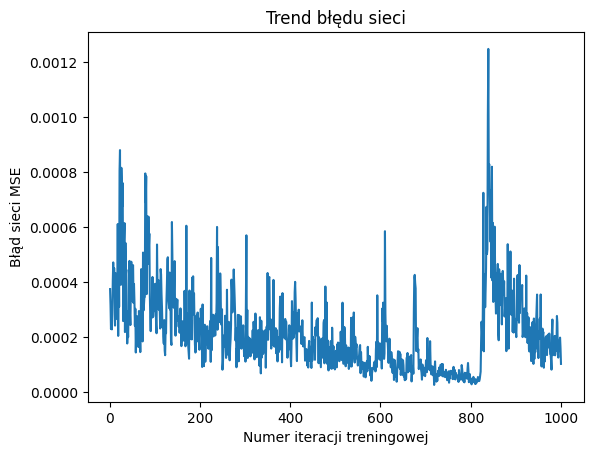

In [537]:
# Konwersja zebranych danych na obiekt DataFrame
training_data_df = pd.DataFrame()
training_data_df['Epochs'] = epochs
training_data_df['Errors'] = training_errors
# Wykres
sns.lineplot(data=training_data_df, x='Epochs', y='Errors')
# Opis wykresu
plt.xlabel('Numer iteracji treningowej')
plt.ylabel('Błąd sieci MSE')
plt.title('Trend błędu sieci')
plt.show()

In [538]:
model.eval()
with torch.no_grad():
    X_test_scaled = X_test_scaled.to(device)
    y_test_scaled = y_test_scaled.to(device)
    test_outputs = model(X_test_scaled)
    test_loss_mse = criterion(test_outputs, y_test_scaled)
    print(f'Błąd średnio-kwadratowy: {test_loss_mse.item():.3f}')


Błąd średnio-kwadratowy: 0.001


In [540]:
with torch.no_grad():
    index = -2
    test_day_data = X_test_scaled[index].unsqueeze(0).to(device)
    predicted_price = model(test_day_data).cpu().numpy()
    predicted_price = scaler.inverse_transform(predicted_price).item()
    actual_price = scaler.inverse_transform(y_test_scaled[index].cpu().unsqueeze(0).numpy()).item()
    print(f"Przewidywana cena: {predicted_price:.2f}$, cena aktualna: {actual_price:.2f}$")

Przewidywana cena: 234.11$, cena aktualna: 229.59$


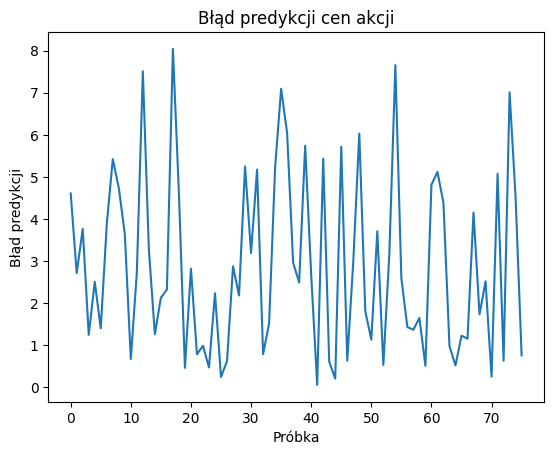

In [543]:
errors = []
with torch.no_grad():
    for i in range(min(76, len(X_test_scaled))):
        test_day_data = X_test_scaled[i].unsqueeze(0).to(device)
        predicted_price = model(test_day_data).cpu().numpy()
        predicted_price = scaler.inverse_transform(predicted_price).item()
        actual_price = scaler.inverse_transform(y_test_scaled[i].cpu().unsqueeze(0).numpy()).item()
        errors.append(abs(actual_price - predicted_price))

plt.plot(errors)
plt.xlabel("Próbka")
plt.ylabel("Błąd predykcji")
plt.title("Błąd predykcji cen akcji")
plt.show()
